# **YOLO?**

YOLO (You Only Look Once)는 이미지 속 객체를 **한 번의 연산으로 빠르게 탐지**할 수 있는 객체 인식 알고리즘으로, 

현재 객체 탐지 분야에서 가장 널리 사용되는 모델 중 하나입니다.

전통적인 객체 탐지 방식은 이미지에서 물체의 위치를 탐색한 뒤 각 위치마다 분류를 따로 수행했지만,  
YOLO는 이미지를 **격자로 나눈 뒤 각 격자에서 물체가 있는지, 있다면 어디에 어떤 물체가 있는지를 한 번에 예측**합니다.

🔹 YOLO의 주요 특징:
- **실시간 처리 가능** → 초당 수십 프레임(FPS) 처리 가능
- **정확한 위치 추정과 빠른 속도**의 균형
- **단순한 구조**로 초보자도 쉽게 사용 가능
- **모델 크기**에 따라 속도-정확도 조절 가능

<img src="https://i.imgur.com/lQj0VLX.png">

In [1]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


# **0. 환경 설정**

YOLO를 학습시키기 위해서는 Python, PyTorch, CUDA 등이 올바르게 설정되어 있어야 하며,  
특히 GPU 환경에서 학습하면 CPU 학습 대비 속도가 **수십 배 빨라지기 때문에 매우 중요**합니다.

아래 코드를 통해 CUDA 버전 호환성, GPU 연결 여부 등을 확인할 수 있습니다:

In [5]:
import torch
import torchvision
print(torch.version.cuda)            # ✅ 예: '11.8'
print(torch.backends.cudnn.enabled)  # ✅ True
print(torch.cuda.is_available())     # ✅ True
print(torch.cuda.get_device_name(0)) # ✅ GPU 이름 출력
print(torchvision.ops.nms)           # ✅ CUDA kernel 등록됨 확인

11.8
True
True
NVIDIA GeForce GTX 1070 Ti
<function nms at 0x000001EE7BCE0A60>


하나라도 false가 출력된 경우 : 그래픽 카드의 기종과 CUDA 버전이 호환되지 않을 경우 false가 출력될 수 있습니다.

Anaconda Prompt에서 아래의 명령어를 순서대로 입력해 현재 cuda 버전을 삭제하고 새로운 버전을 설치해볼 수 있습니다. 

**삭제 명령어 :** 

pip uninstall torch torchvision torchaudio

**캐시 삭제 명령어 :** 

pip cache purge

**설치 명령어 (새로운 버전 설치 시 사전에 삭제 명령어 반드시 사용) :**

pip install torch==1.13.1+cu102 torchvision==0.14.1+cu102 torchaudio==0.13.1 -f https://download.pytorch.org/whl/torch_stable.html

pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# **1. 데이터 라벨링**

머신러닝에서 데이터는 모델이 **보고 배우는 예시**입니다.

따라서 다양하고 충분한 데이터는 모델 성능을 좌우하는 핵심 요소가 되며, 그 **양적인 측면(데이터 수)** 과 **질적인 측면(라벨링 일관성, 노이즈 등)** 모두 중요합니다.

YOLO는 이미지를 학습할 때 각 이미지에 대해 **객체가 어디에 있는가**와 **해당 객체가 무엇인지**에 대한 정보가 필요합니다.  
이를 위해 다음 3가지의 파일이 요구됩니다:

<font size="3">1. 📷 이미지 파일 (`.jpg` 또는 `.png`) → 모델이 학습할 입력 이미지<br>
<font size="3">2. 📝 라벨 텍스트 파일 (`.txt`) → 객체의 class 번호, 위치<br>
<font size="3">3. 📄 클래스 목록 파일 (`classes.txt`) → 클래스 번호에 대응하는 클래스 명<br>

🔹 **데이터 라벨링이란?**
: 사람이 직접 **이미지 속 객체의 위치와 클래스 정보를 기록**하는 작업입니다.

예를 들어, "사람"이 있는 이미지를 라벨링 한다면 다음과 같은 텍스트 파일이 생성됩니다 :

0 0.523 0.618 0.210 0.350 &nbsp;&nbsp; → 클래스 번호, 중심좌표 x, 중심좌료 y,  너비 w, 높이 h

🔹 **라벨링 도구**

데이터 라벨링은 사람이 수작업으로 진행하지만 이를 지원하는 다양한 툴이 존재합니다. 

이 교안에서는 Anaconda의 가상환경에서 **Label Studio**를 실행하여 라벨링 실습을 진행합니다.

# **Label Studio**

- 다양한 라벨링 방식을 지원하는 웹 기반 툴

- 이미지, 텍스트, 오디오 등 다양한 파일에 대한 라벨링 지원

- YOLO 포맷 포함 다양한 추출 포맷 제공

- 웹 기반으로 작동하나, Anaconda 가상환경에서 사용하면 안정성 상승

- Anaconda Prompt를 통한 **가상환경 설치**가 필요

Anaconda Prompt 실행 후, 아래의 명령어를 순차적으로 입력해 가상환경에 Label Studio 설치 및 실행할 수 있습니다.

1. **conda activate yolo_edu** &nbsp; <-- yolo_edu 환경 활성화

2. **pip install label-studio** &nbsp;&nbsp;&nbsp; <-- label studio 설치 명령어

3. **label-studio start** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <-- label studio 시작 명령어

<img src="https://i.imgur.com/Vq9Zkva.png" style="height:75px;">

아래의 절차를 따라 라벨링을 진행할 수 있습니다.

<font size="4">0. 회원가입 및 로그인

<img src="https://i.imgur.com/8OcuSNH.png" style="height:500px;">>

Label Studio는 웹 기반 인터페이스이기 때문에, 처음 실행 시 회원가입 및 로그인 절차가 필요합니다.

Anaconda 가상환경에서 실행한 경우, **실제 이메일 인증 없이 임의의 계정 정보로** 회원가입이 가능합니다.

단, 이전에 진행한 라벨링 작업을 불러오거나 이어서 하려면 반드시 **같은 계정 정보로 로그인**해야 합니다.

<font size="4">1. 프로젝트 생성

create project를 통해 라벨링 프로젝트를 생성합니다.

<img src="https://i.imgur.com/QwlKsbj.png" style="height:500px;">

<font size="4">2. 프로젝트 환경 설정

Data Import 탭의 Upload Files를 통해 파일을 업로드 할 수 있습니다.

마우스를 드래그해 여러 이미지를 한 번에 업로드할 수 있습니다. ***데이터 업로드 시 한 번에 업로드 가능한 이미지는 100장으로 제한**

<img src="https://i.imgur.com/ri3Q4PD.png" style="height:600px;">

Labeling Setup 탭에서 라벨링 방식을 설정할 수 있습니다.

다각형 분할, 핵심 지점 태그, 픽셀 단위 마스킹 등 다양한 라벨링 방법이 존재합니다.

이번 실습에선 YOLO 포맷에 알맞은 **Bounding Boxes** 방법으로 진행합니다.

<img src="https://i.imgur.com/iTnGhLA.png" style="height:650px;">

<img src="https://i.imgur.com/mS8fBDw.jpeg" style="height:600px;">

1. x를 클릭해 라벨을 삭제할 수 있습니다.
2. 해당 빈 칸에 클래스 이름을 입력합니다.
3. Add를 클릭해 해당 클래스를 라벨로 추가합니다.

라벨을 클릭해 라벨의 색상을 변경할 수도 있습니다.

<img src="https://i.imgur.com/ccDg943.png" style="height:300px;">

모든 설정이 완료되면 Save를 클릭해 설정을 완료합니다.

<font size="4">3. 라벨링

파일이 업로드 된 순서대로 ID가 부여되고, Label All Tasks 버튼을 클릭해 모든 파일에 대해 라벨링을 진행할 수 있습니다.


<img src="https://i.imgur.com/sAW2p3I.png" style="height:600px;">

<img src="https://i.imgur.com/wUYnISM.jpeg" style="height:700px;">

1. 라벨을 선택합니다.

2. 원하는 지점을 클릭 후 드래그하면 드래그 경로를 따라 바운딩 박스가 생성되며, 해당 지점이 라벨링 됩니다.

라벨링을 마치면 프로젝트 탭을 눌러 작업을 완료할 수 있습니다.

<img src="https://i.imgur.com/74deyUJ.png" style="height:400px;">

<font size="4">4. 파일 추출

3의 과정을 통해 모든 파일에 대해 라벨링을 완료했다면 파일을 추출할 차례입니다.


<img src="https://i.imgur.com/xD2rcCD.png" style="height:400px;">

1. 프로젝트 우측 상단의 Export 클릭
2. YOLO with Images 포맷 선택
3. 하단 Export 클릭

해당 포맷을 선택해 다음과 같은 구성의 zip 파일을 다운로드 받을 수 있습니다.

<img src="https://i.imgur.com/IzBDyF4.png" style="height:120px;"></td>

- images 폴더 : 학습에 사용할 이미지 파일이 저장된 폴더
- labels 폴더 : 학습에 사용할 라벨 정보 텍스트 파일이 저장된 폴더
- classes.txt : 클래스 명(라벨 이름)이 적힌 텍스트 파일
- notes.json : JavaScript Object Notation 파일. **YOLO 학습에선 미사용**

# **2. 데이터 세팅**

# **2.1 데이터 업로드**

라벨링을 마친 zip 파일을 교안이 담긴 프로젝트 폴더로 옮겨줍니다. 또한 파일명을 **data**로 변경하고 압축을 해제해 줍니다.

<img src="https://i.imgur.com/6Y3lRM5.png" style="height:150px;">

<br>실습 간 아래의 샘플 데이터셋을 사용해볼 수 있습니다.

🔹&nbsp;**샘플 데이터셋 : 안전모 착용 감지 데이터셋**

샘플 데이터셋은 **Roboflow**에서 제공하는 **Hard Hat Workers Dataset**을 재구성한 것으로 1000장의 이미지가 head, helmet, person 총 3가지의 클래스에 대해 라벨링 되어 있습니다.

본 데이터셋을 활용하여 공사장 인부의 안전모 착용 여부를 YOLO 모델로 탐지하는 실습을 진행할 수 있습니다.

아래의 링크에서 샘플 데이터 파일을 다운로드 해볼 수 있습니다.

https://github.com/RML-KSJ/YOLO_sample_data/releases/tag/release-2025

또는 아래의 코드 실행으로 프로젝트 폴더에 바로 데이터를 업로드할 수 있습니다.

*간혹 경고 문장이 출력될 수 있지만 **코드를 다시 실행**하면 정상적으로 업로드가 완료됩니다.

In [2]:
import requests

url = "https://github.com/RML-KSJ/MachineLearning_EDU/releases/tag/YOLO_release-2025/data.zip"
with open("data.zip", "wb") as f:
    f.write(requests.get(url).content)

업로드가 완료됐다면 아래의 코드를 통해 업로드 한 파일을 압축 해제할 수 있습니다.  

In [4]:
import zipfile, os

with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extractall("data")

print("압축 해제 완료")
print("폴더 내 파일 목록:", os.listdir("data"))

압축 해제 완료
폴더 내 파일 목록: ['classes.txt', 'images', 'labels', 'README.dataset.txt', 'README.roboflow.txt']


# **2.2 데이터 분리**

YOLO 학습에는 보통 다음과 같이 데이터를 구성합니다 :
- **Train data**: 모델이 학습에 사용하는 데이터 (보통 80~90%)
- **Validation data**: 모델이 얼마나 잘 학습되고 있는지를 검증하는 데이터 (10~20%)

훈련 데이터와 검증 데이터를 분리하는 것은 **훈련에 사용되지 않은 데이터로 모델의 일반화 성능을 점검하기 위함**입니다.

아래의 코드는 데이터를 자동으로 분류해주는 코드입니다. 

분류된 데이터는 실제 경로가 변경되진 않지만 분류 정보가 담긴 텍스트 파일을 생성하여 저장합니다.

In [5]:
# 압축 해제된 경로 확인
# 기본 경로 : C:\사용자\사용자 이름\yolo_edu
# \yolo_edu\data\images\*.jpg
# \yolo_edu\data\labels\*.txt

# autosplit 실행
# 분할 비율 : weights(train, validation, test)
from ultralytics.data.split import autosplit
autosplit(path='data/images', weights=(0.9, 0.1, 0), annotated_only=True)

Autosplitting images from data\images, using *.txt labeled images only


100%|██████████| 989/989 [00:00<00:00, 2188.09it/s]


# **3. YAML**

모델을 학습시키기 전에, 모델에게 데이터셋의 구조를 이해시키는 파일이 필요합니다. 이때 사용하는 파일이 **.yaml** 파일입니다.

해당 파일은 모델이 어떤 데이터로 학습하고 어떤 클래스가 있는지, 어떤 데이터로 검정하는지 이해하도록 돕습니다.

🔹`.yaml` 파일 구성 및 특징
- 📁 학습, 검증 데이터의 이미지 및 라벨 경로
- 🏷️ 클래스 수
- 📝 클래스 이름 목록
- 직관적인 구조
- 복잡한 설정 없이 편집 가능

In [6]:
import os
import yaml

def create_data_yaml_for_autosplit(path_to_classes_txt, path_to_data_yaml):
    """
    autosplit을 통해 생성된 분류 텍스트 파일과 classes.txt를 기반으로
    YOLO 학습용 data.yaml 파일을 생성하는 함수
    """

    # 1. classes.txt 존재 확인
    if not os.path.exists(path_to_classes_txt):
        print(f'❌ classes.txt 파일이 존재하지 않습니다: {path_to_classes_txt}')
        return

    # 2. 클래스 이름 읽기
    with open(path_to_classes_txt, 'r') as f:
        classes = [line.strip() for line in f if line.strip()]
    number_of_classes = len(classes)

    # 3. data.yaml 구조 정의
    data = {
        'train': 'autosplit_train.txt',
        'val': 'autosplit_val.txt',
        'nc': number_of_classes,
        'names': classes
    }

    # 4. YAML 파일 생성
    with open(path_to_data_yaml, 'w') as f:
        yaml.dump(data, f, sort_keys=False)

    print(f'✅ data.yaml 생성 완료: {path_to_data_yaml}')

# ✅ 실행
create_data_yaml_for_autosplit('data/classes.txt', 'data/data.yaml')

✅ data.yaml 생성 완료: data/data.yaml


# **4. 모델 학습**

YOLO는 **기존에 학습된 모델(사전 학습 모델)** 에 **사용자 데이터를 추가로 학습(fine-tuning)** 시켜 새로운 모델을 만드는 구조입니다.

통합 학습 명령어 yolo detect train 을 통해 학습과 검증을 동시에 진행할 수 있으며, 필수 파라미터인 data, model을 정해주어야 합니다.

- data : 사용할 학습용 데이터

- model : 사용할 YOLO 모델 종류

🔹&nbsp;모델의 종류에 따른 성능 차이

모델 이름의 **접미사**에 따라 학습 속도, 정확도가 달라집니다.

- yolo11s : small - 속도 빠름, 정확도 낮음

- yolo11m : medium - 속도 보통, 정확도 보통

- yolo11l : large - 속도 느림, 정확도 높음

학습이 완료되면 최종 성능이 가장 좋은 모델이 best.pt로 저장됩니다.

📂저장 경로 : runs/detect/train/weights/best.pt

🔹&nbsp;실습 : 기본 구조를 이해하기 위해 **두 가지의 방법**으로 학습 진행

- case A : 최소 설정값으로 간단한 학습, 모델 학습의 기본 흐름 확인

- case B : 다양한 파라미터를 조정, 모델의 성능 변화 확인


# **4.1 모델 학습 : case A**

YOLO 모델 학습에서 model은 사용자가 반드시 지정해야 하는 필수 파라미터 입니다.

case A 에서는 최소한의 설정으로 학습을 진행하며, 학습 시간을 줄이기 위해 epochs 값만 낮춰 진행하겠습니다.

또한 학습 과정을 실시간으로 확인하기 위해 subprocess를 활용하여 cmd 명령어를 실행하는 방식을 사용하겠습니다. 

In [7]:
import subprocess

# YOLO 학습 명령어
cmd = [
    "yolo", "detect", "train",
    "data=data/data.yaml",
    "model=yolo11s.pt",
    "name=yolo_caseA",
    "epochs=50"
]

# 실시간 출력 확인
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

# 출력 스트리밍
for line in process.stdout:
    print(line, end='')


process.wait()

# 오류 체크
if process.returncode != 0:
    print(f"\n❌ 학습 중 오류 발생 (종료 코드: {process.returncode})")
else:
    print("\n✅ 학습이 정상적으로 완료되었습니다.")


C:\Users\RML\anaconda3\envs\yolo_edu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(

  0%|          | 0.00/18.4M [00:00<?, ?B/s]
 35%|###5      | 6.50M/18.4M [00:00<00:00, 68.1MB/s]
 84%|########4 | 15.5M/18.4M [00:00<00:00, 83.1MB/s]
100%|##########| 18.4M/18.4M [00:00<00:00, 81.2MB/s]
Ultralytics 8.3.168  Python-3.10.18 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1070 Ti, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freez

# **4.2 모델 학습 : case B**

하이퍼 파라미터는 별도로 설정하지 않으면 기본값으로 작동합니다. 하지만 모델의 학습 효율, 성능 향상을 위해 값을 **직접 조정(tuning)** 할 수 있습니다.

- epochs : 학습의 반복 횟수

- imgsz : 이미지 크기

- batch : 한 번에 처리할 데이터 수

- learning rate (lr): 데이터에 대한 학습률

- weight decay : 가중치 조절

- optimizer : 최적화 함수

case B 에선 다양한 파라미터를 조정하여 모델을 학습시켜 보고, 해당 파라미터 조정이 성능에 어떤 영향을 미치는지 확인해 보겠습니다.

In [5]:
import subprocess

# YOLO 학습 명령어 (하이퍼파라미터 직접 삽입)
cmd = [
    "yolo", "detect", "train",
    "data=data/data.yaml",
    "model=yolo11s.pt",
    "epochs=50",
    "imgsz=800",
    "batch=16",
    "cos_lr=True",
    "lr0=0.01",
    "lrf=0.001",
    "weight_decay=0.0010",
    "optimizer=SGD",
    "name=yolo_caseB"
]

# 실시간 출력 확인
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

# 출력 스트리밍
for line in process.stdout:
    print(line, end='')

process.wait()

# 오류 체크
if process.returncode != 0:
    print(f"\n❌ 학습 중 오류 발생 (종료 코드: {process.returncode})")
else:
    print("\n✅ 학습이 정상적으로 완료되었습니다.")


C:\Users\RML\anaconda3\envs\yolo_edu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Ultralytics 8.3.168  Python-3.10.18 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1070 Ti, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=y

# **5. 결과 확인**

앞서 yolo detect train 명령어를 통해 case A, case B 모델 학습을 수행했습니다.

다양한 결과 지표들 중 주요한 지표가 담긴 results.png 파일과 Confusion Matrix.png 파일로 모델의 성능을 확인해 보겠습니다.

**📊 주요 결과 지표 : results.png**
- train/box_loss : 학습 데이터 바운딩 박스 위치 오차
  
- train/cls_loss : 학습 데이터 클래스 분류 손실
  
- train/dfl_loss : 학습 데이터 바운딩 박스 위치 분포 오차

- metrics/precision(B) : 탐지한 객체에 대한 정답률

- metrics/recall(B) : 이미지에 존재하는 객체 수의 탐지율

- val/box_loss : 검증 데이터 바운딩 박스 위치 오차

- val/cls_loss : 검증 데이터 클래스 분류 손실

- val/dfl_loss : 검증 데이터 바운딩 박스 위치 분포 오차

- metrics/mAP50(B) : 보통 수준의 정밀도에서의 관측값

- metrics/mAP50-95(B) : 높은 수준의 정밀도에서의 관측값

**🔍 결과 시각화 지표 : Confusion Matrix**
- 각 클래스에 대해 예측 횟수, 실제 횟수의 관계를 **정방 행렬**로 정렬하여 시각화

- 객체가 존재하지 않는 지점을 background 클래스로 추가하여 모델이 **객체의 존재**를 감지하고 있는지 확인 가능

- 모델이 잘 예측하는지 한 번에 확인 가능

📂저장 경로 : runs/detect/모델 명(yolo_caseA 또는 yolo_caseB)/

# **5.1 case A**

case A의 결과 지표를 출력합니다.


📂 results.png


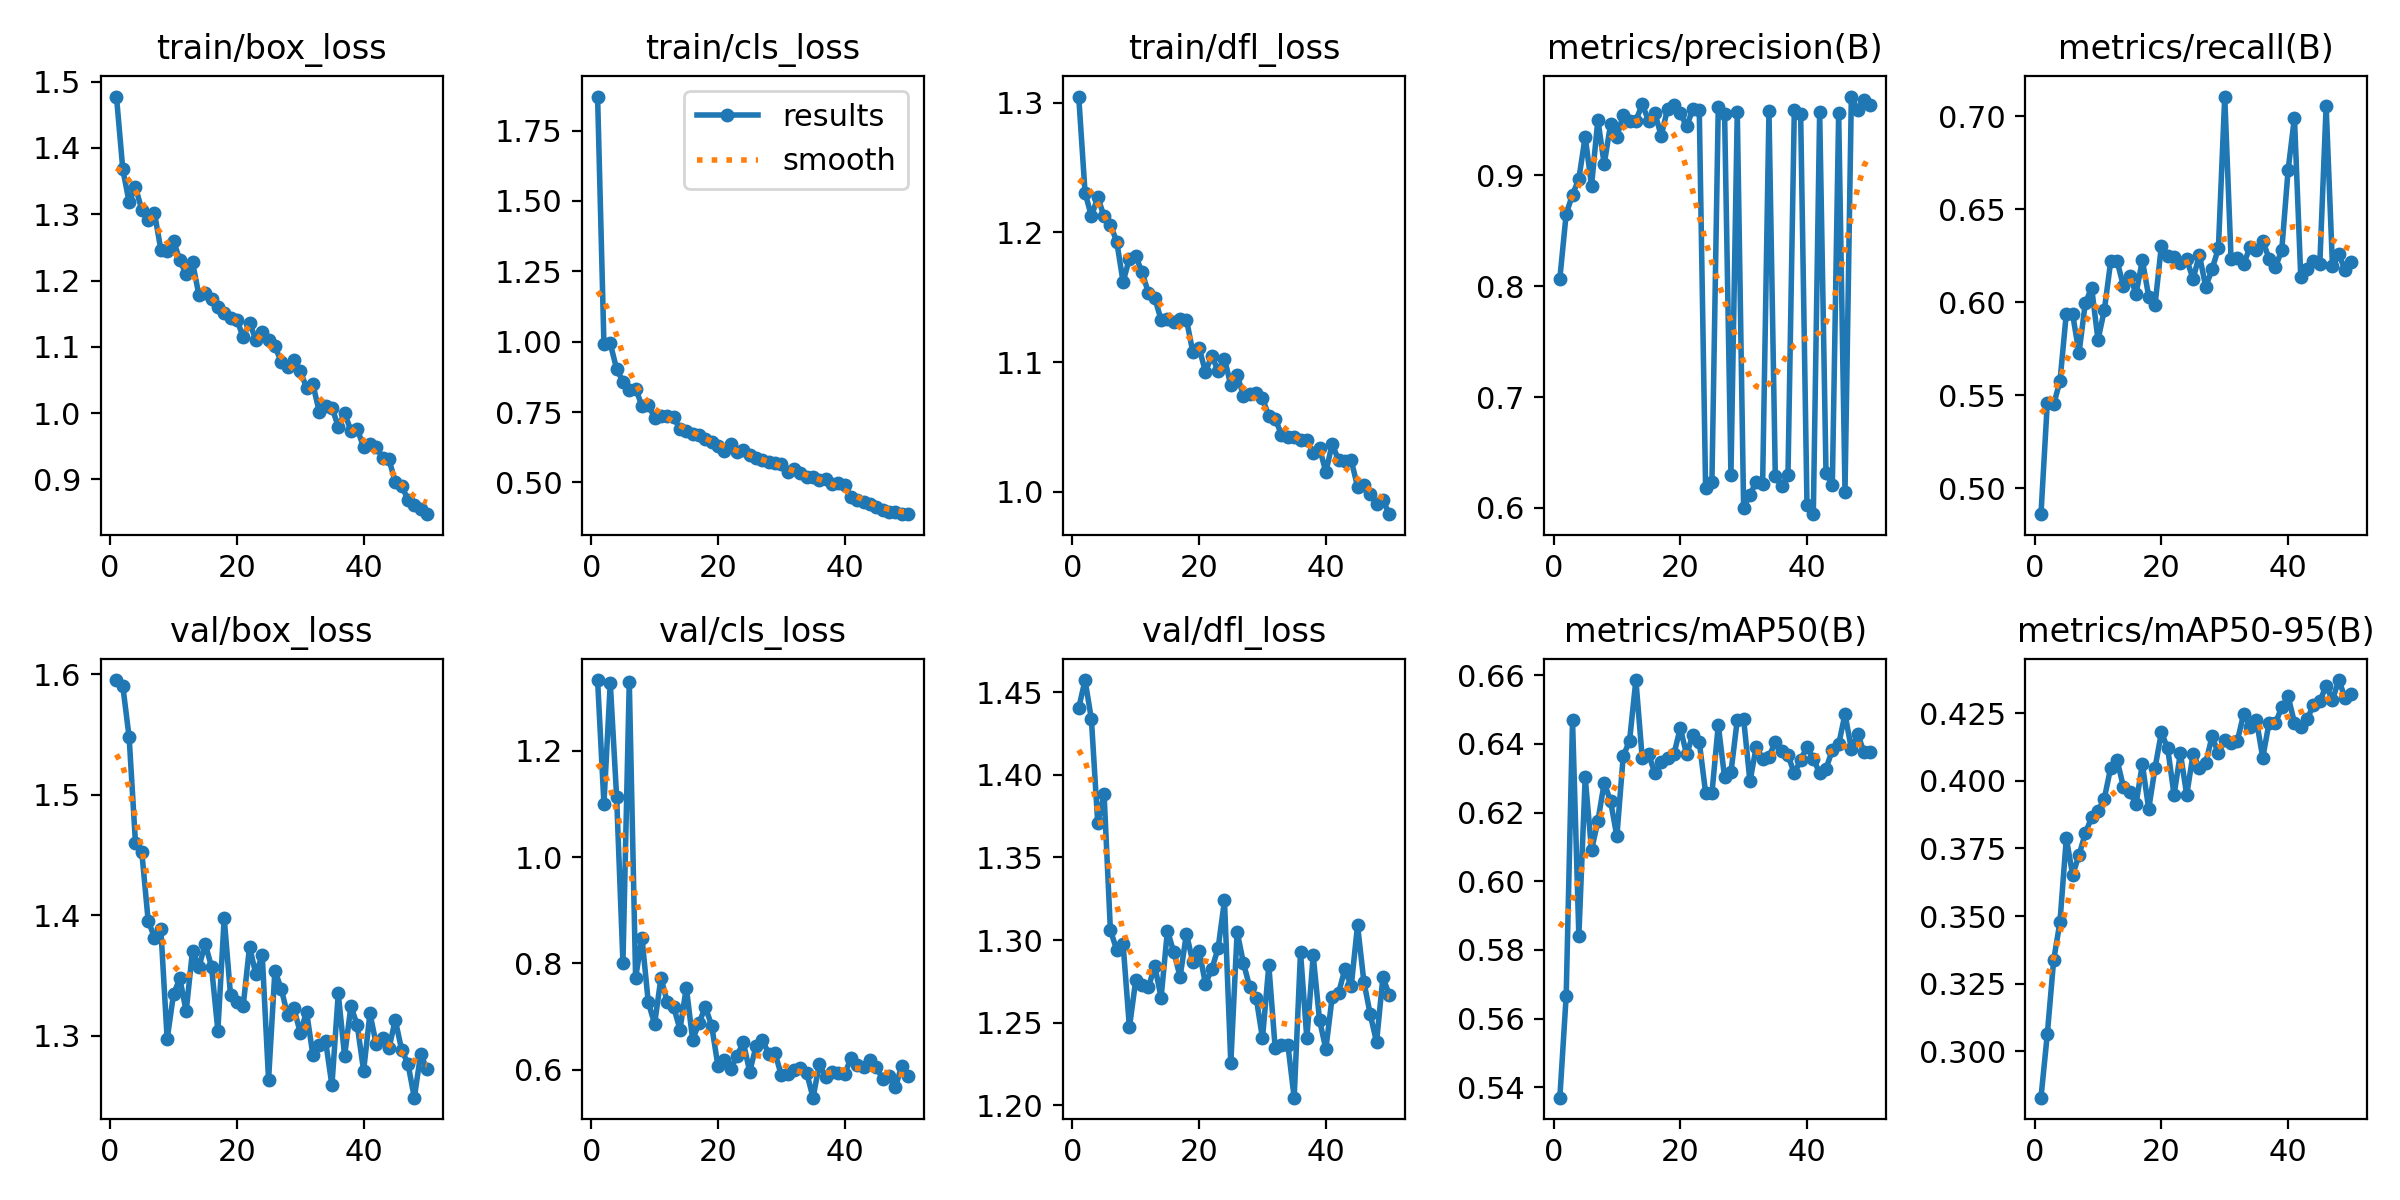


📂 confusion_matrix_normalized.png


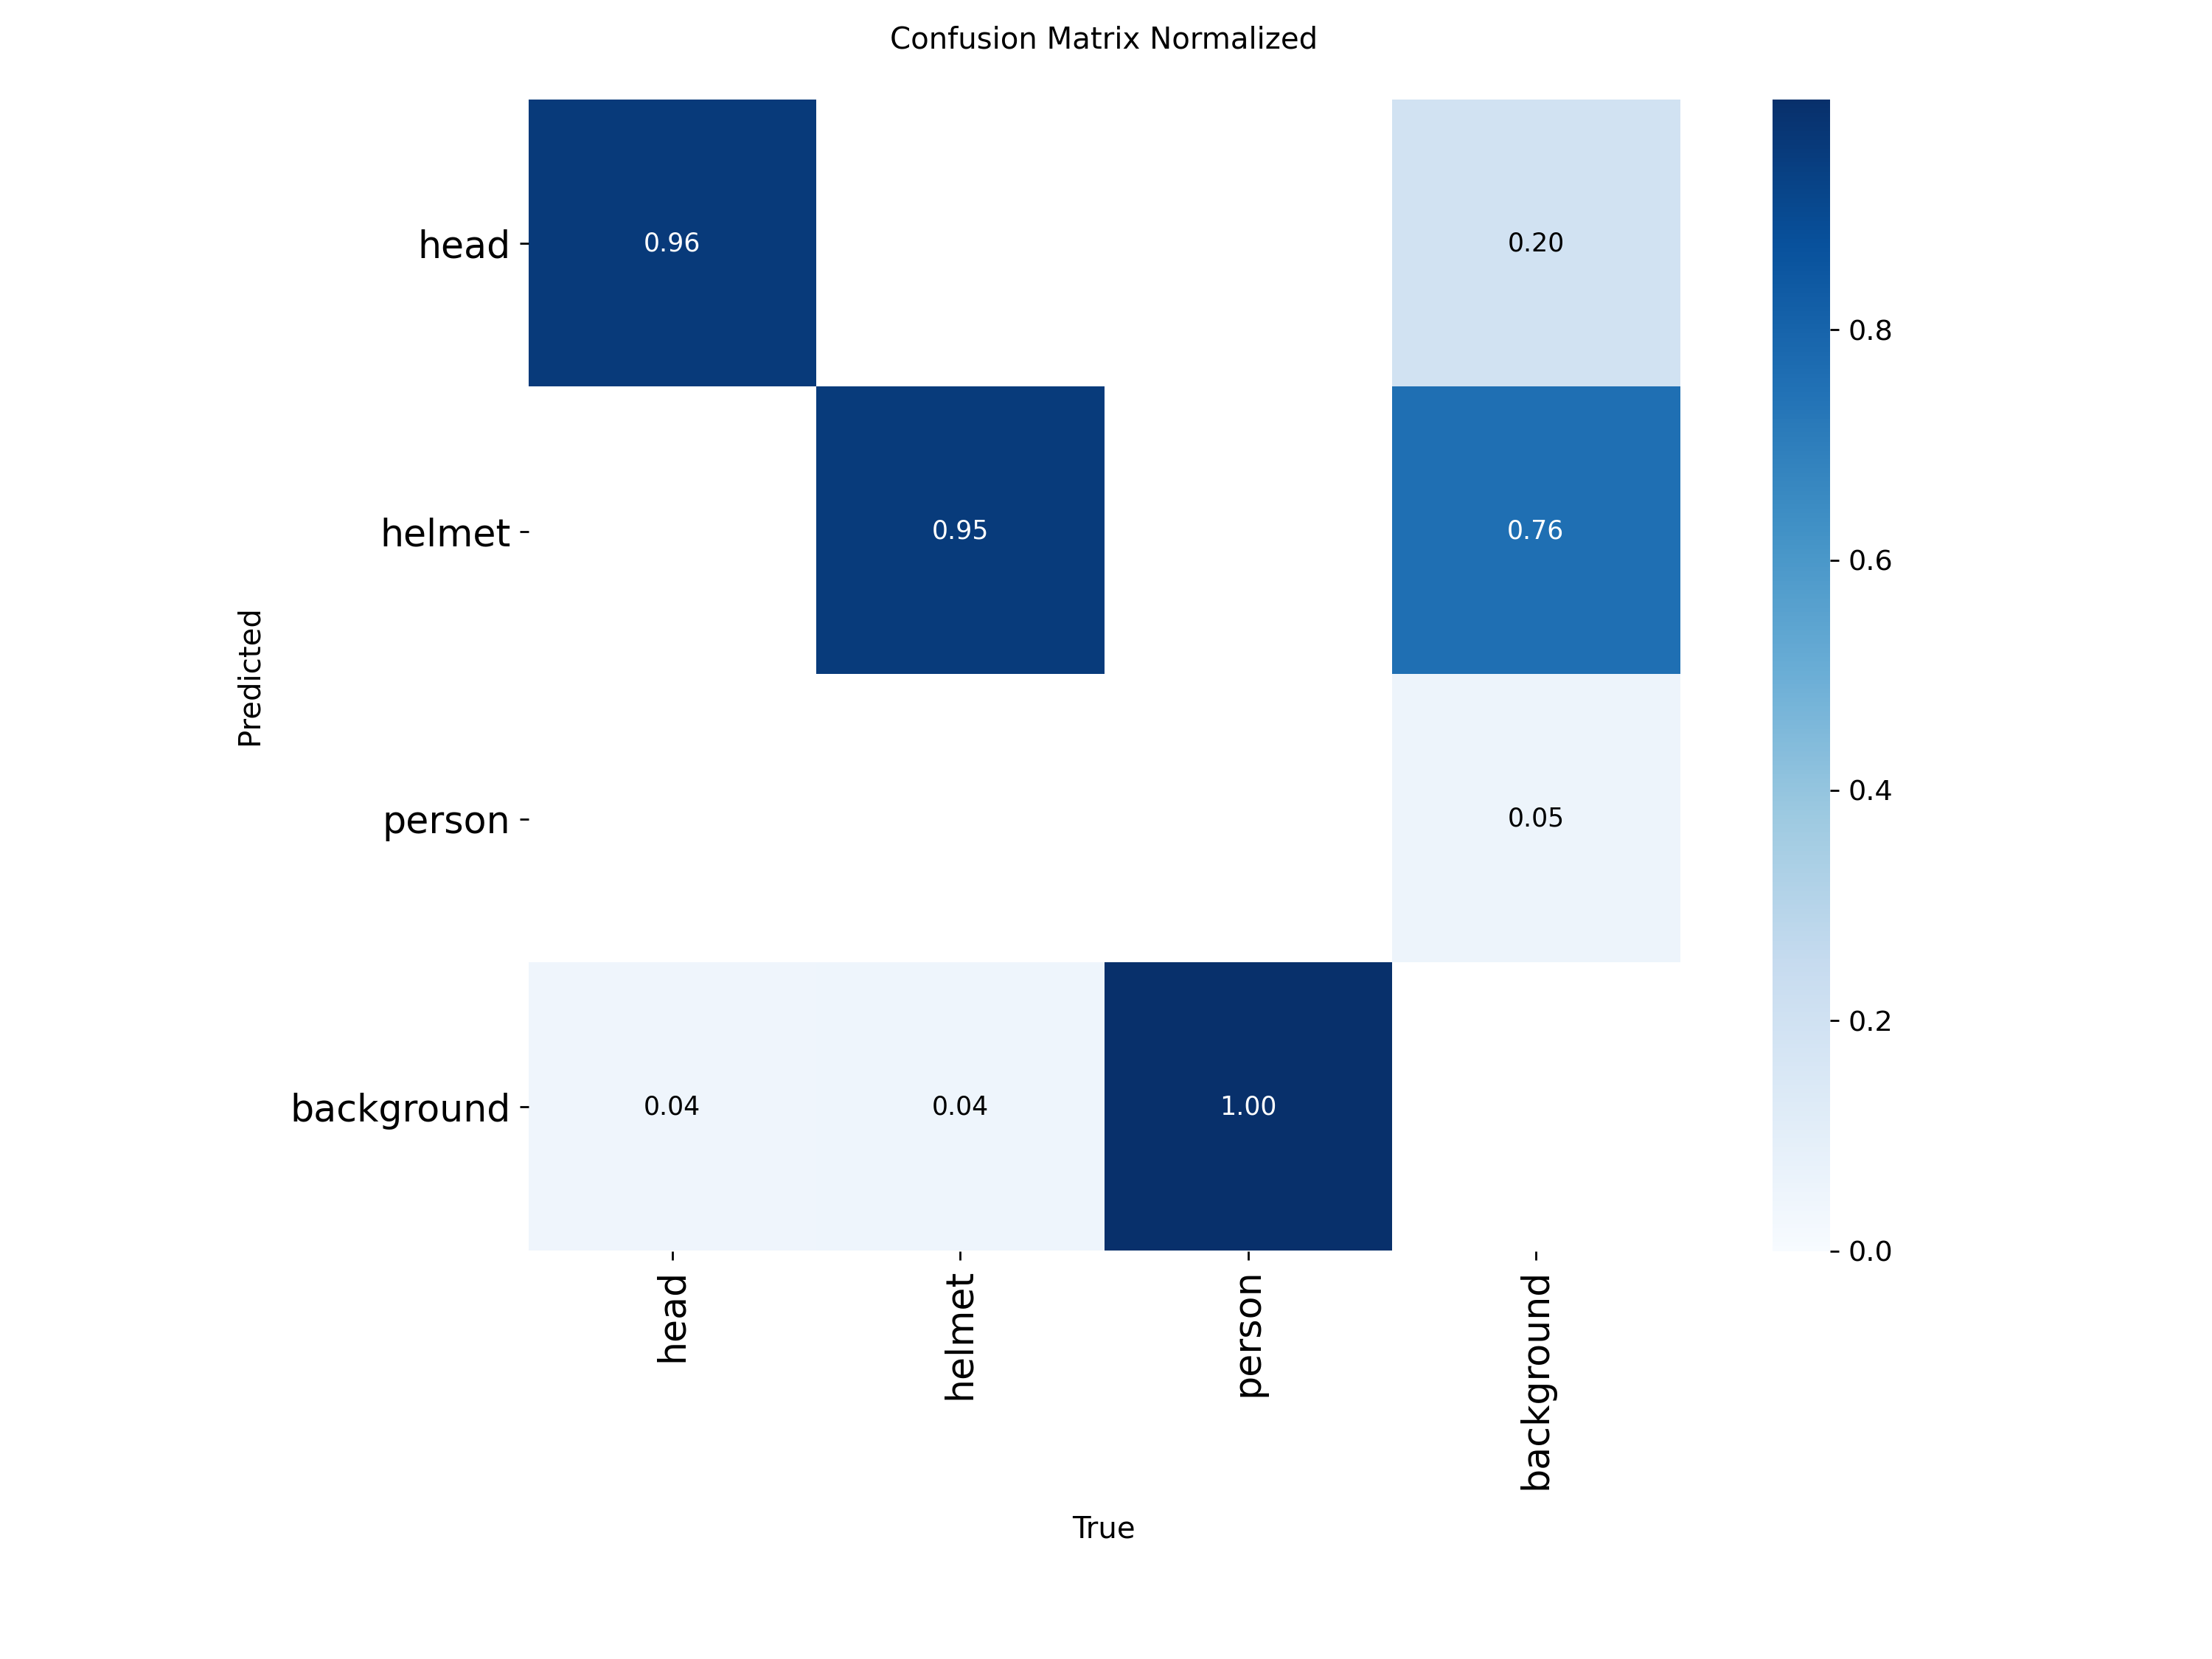

In [3]:
from IPython.display import Image, display
import os

# 결과 이미지가 저장된 경로
base_path = r"C:\Users\RML\yolo_edu\runs\detect\yolo_caseA"

# 출력할 평가 이미지 리스트
visual_files = [
    "results.png",                 # Loss 및 mAP 변화 추이
    "confusion_matrix_normalized.png"  # 정규화된 혼동 행렬
]

# 이미지 출력
for file in visual_files:
    img_path = os.path.join(base_path, file)
    if os.path.exists(img_path):
        print(f"\n📂 {file}")
        display(Image(filename=img_path))
    else:
        print(f"⚠️ 파일 없음: {file}")


# **5.2 case B**

case B의 결과 지표를 출력합니다.


📂 results.png


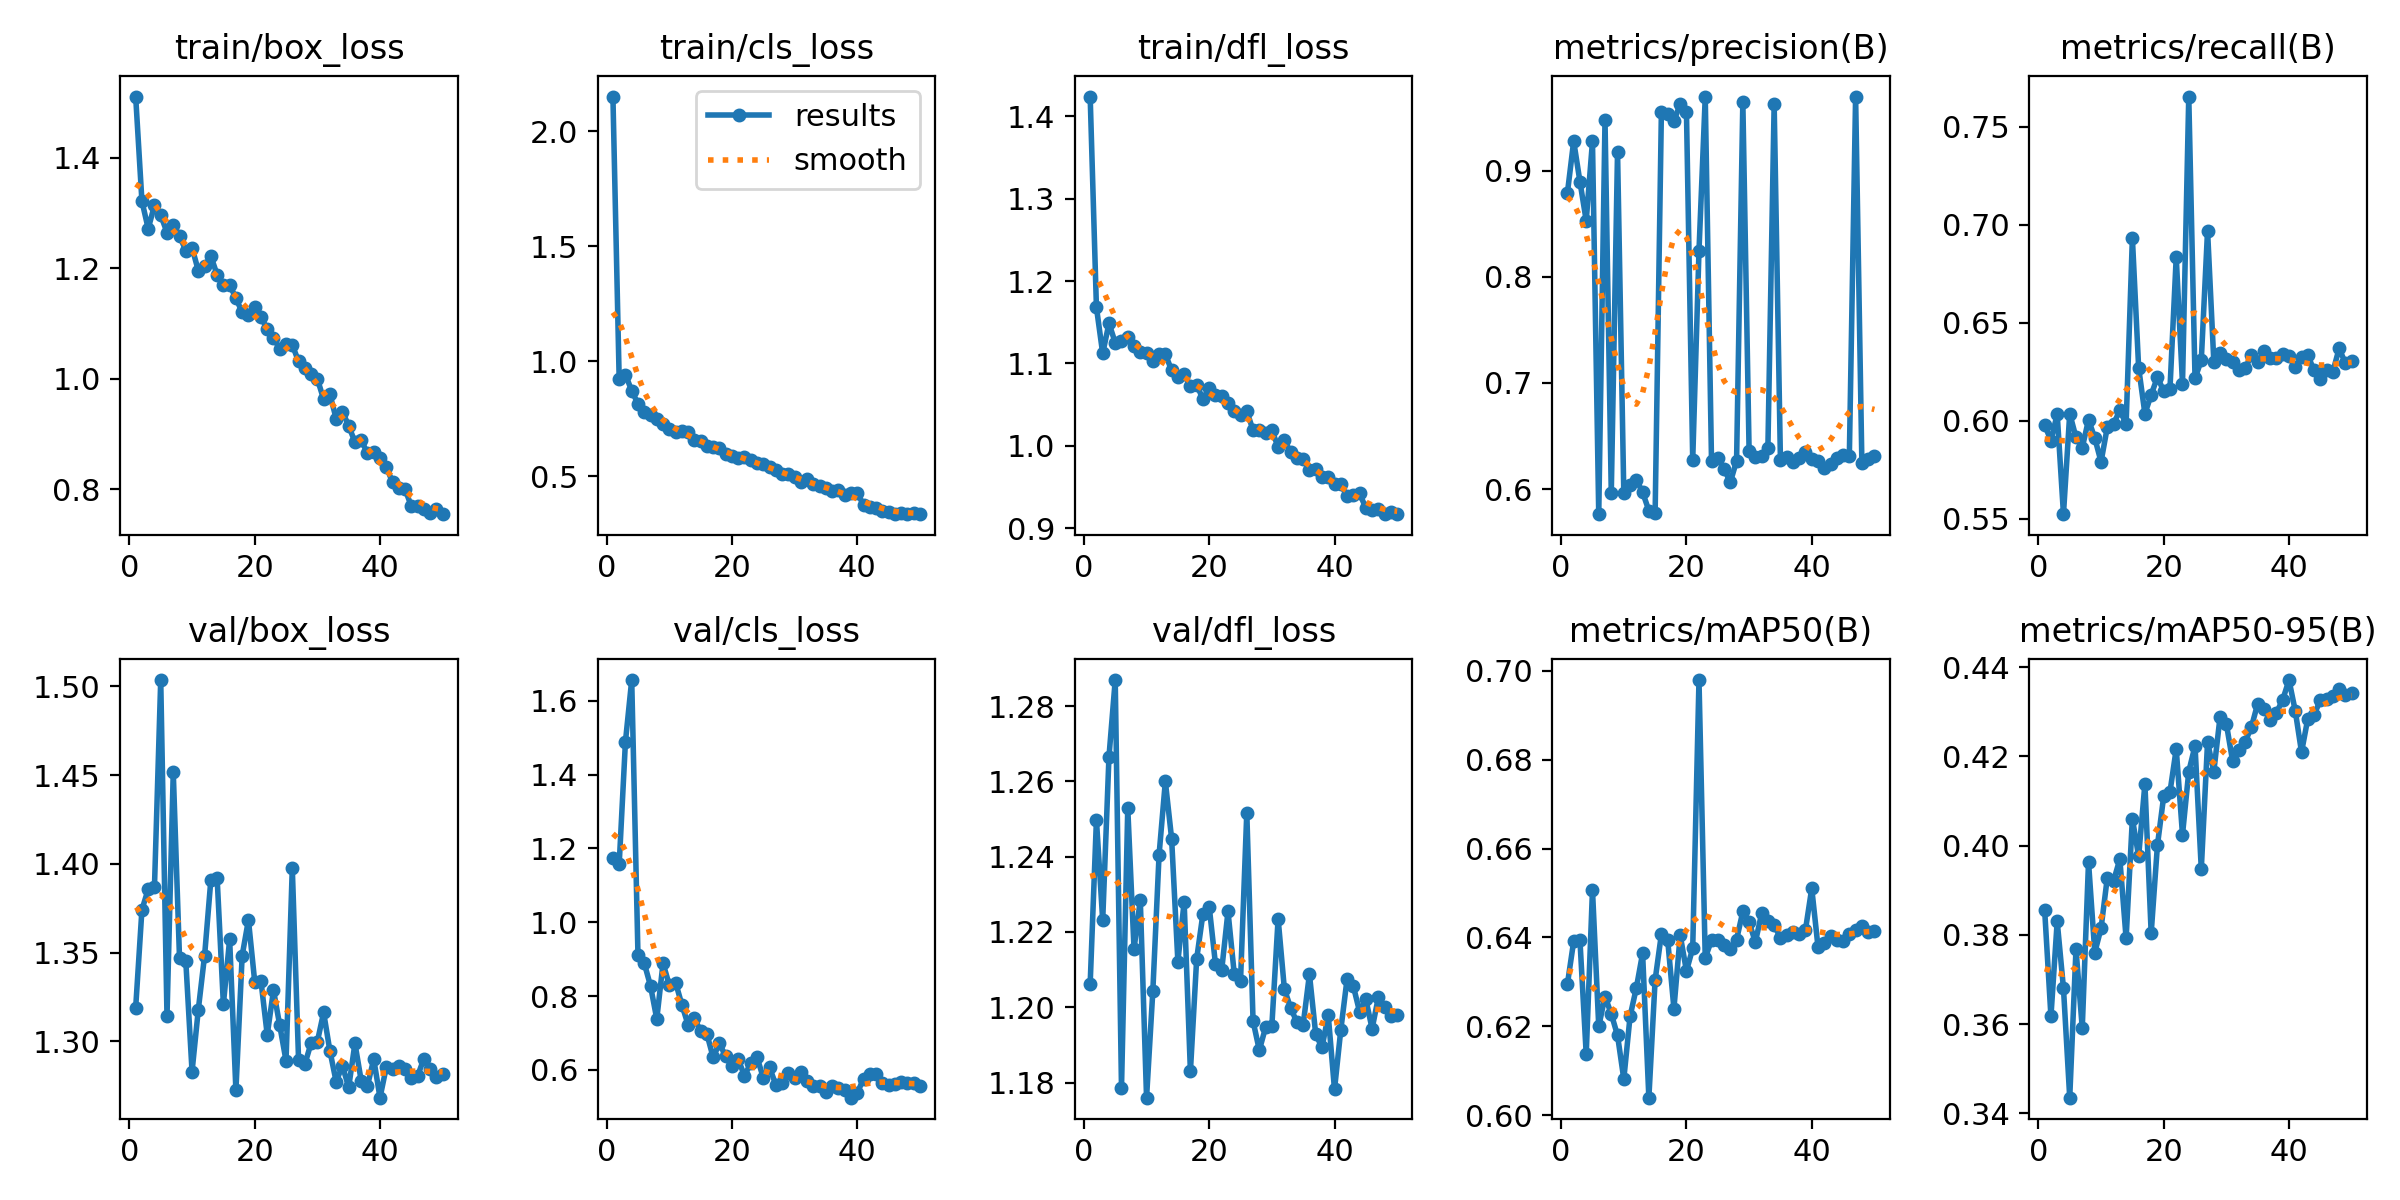


📂 confusion_matrix_normalized.png


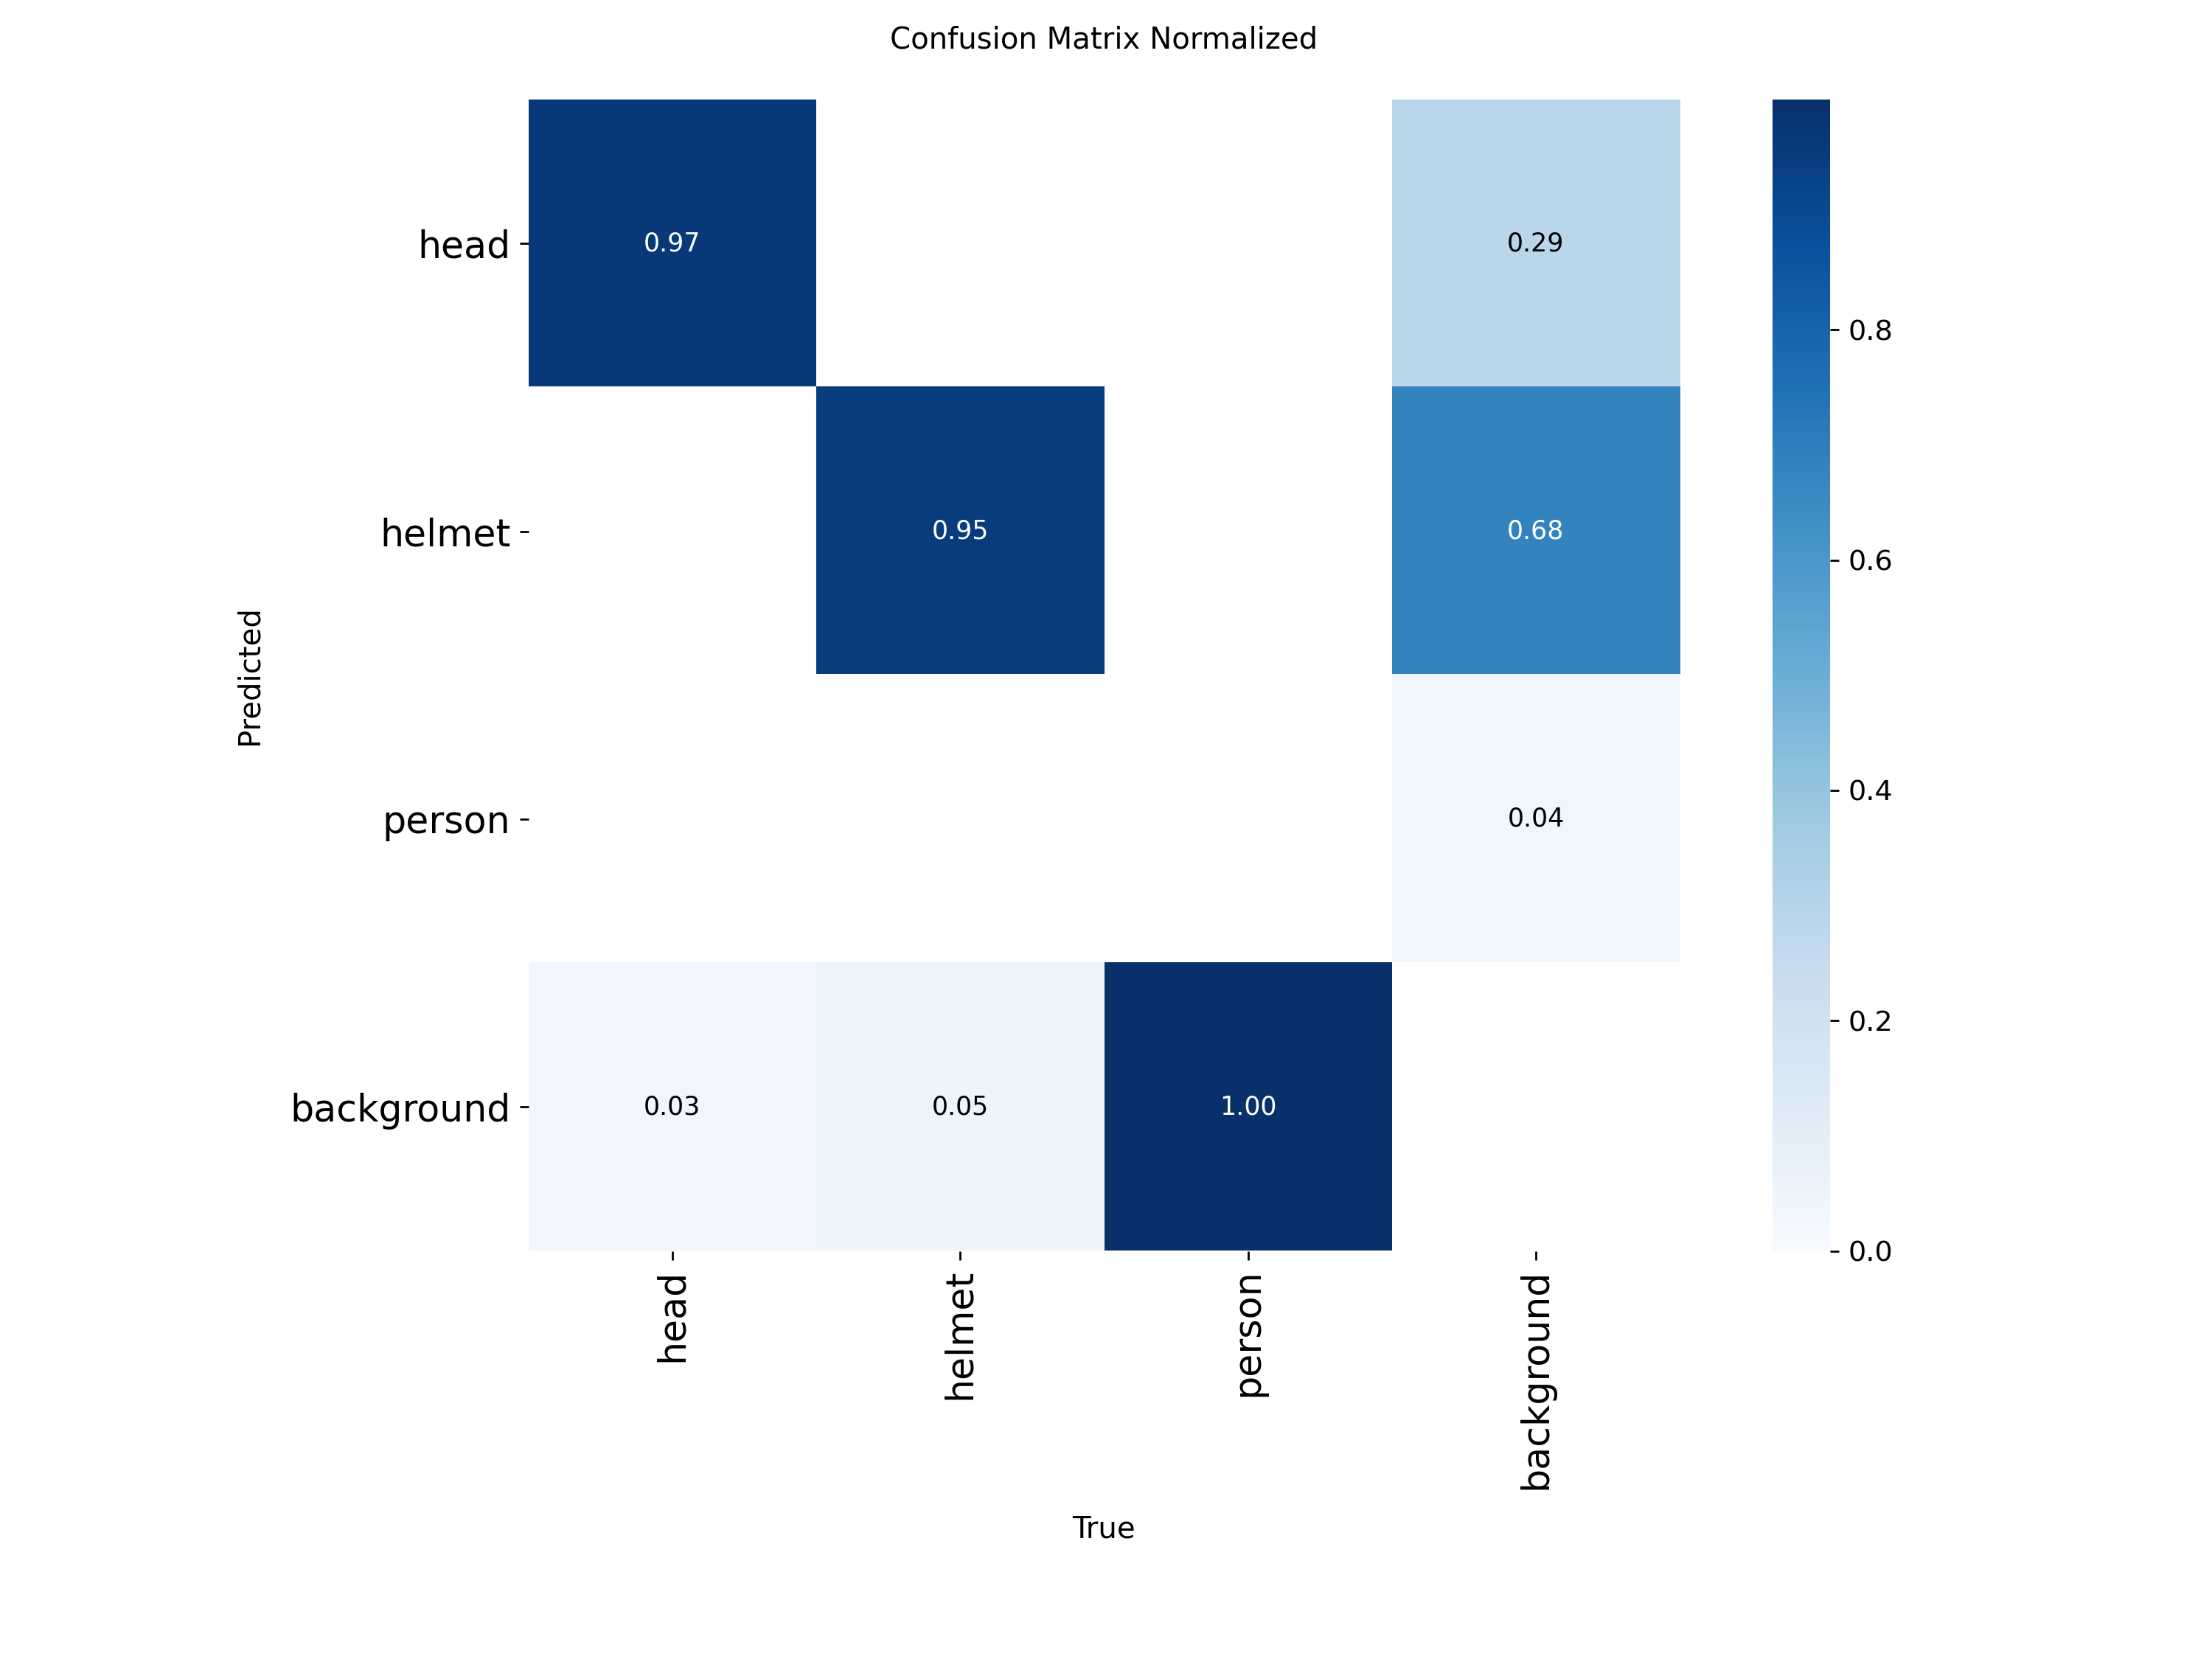

In [8]:
from IPython.display import Image, display
import os

# 결과 이미지가 저장된 경로
base_path = r"C:\Users\RML\yolo_edu\runs\detect\yolo_caseB"

# 출력할 평가 이미지 리스트
visual_files = [
    "results.png",                 # Loss 및 mAP 변화 추이
    "confusion_matrix_normalized.png"  # 정규화된 혼동 행렬
]

# 이미지 출력
for file in visual_files:
    img_path = os.path.join(base_path, file)
    if os.path.exists(img_path):
        print(f"\n📂 {file}")
        display(Image(filename=img_path))
    else:
        print(f"⚠️ 파일 없음: {file}")


# **5.3 성능 비교**

case A와 case B의 성능 지표를 비교해 보겠습니다.

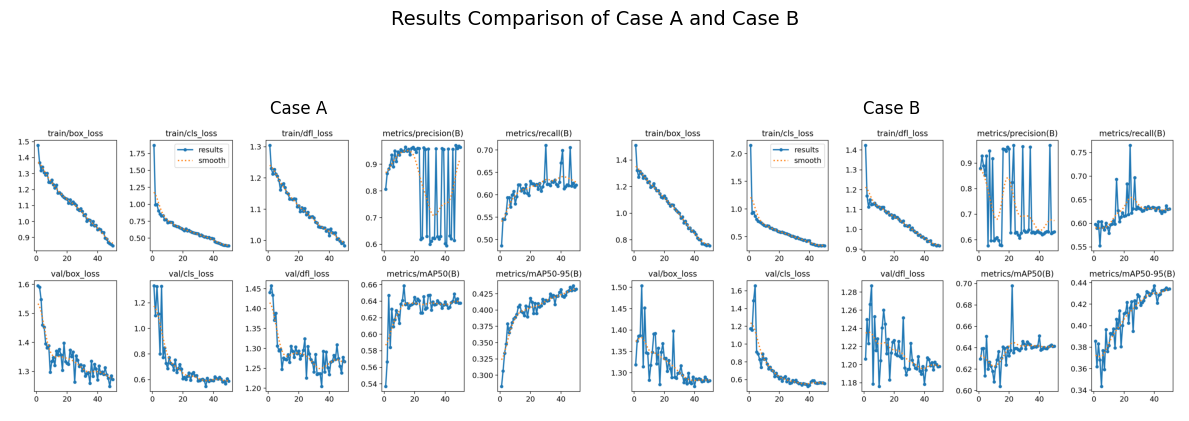

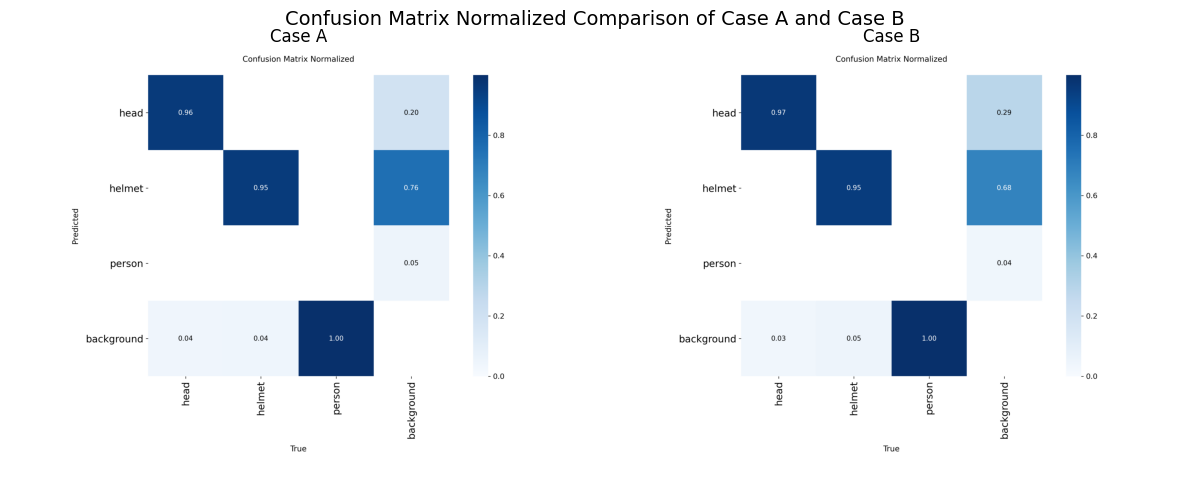

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# 각 모델의 결과 폴더 경로
caseA_path = r"C:\Users\RML\yolo_edu\runs\detect\yolo_caseA"
caseB_path = r"C:\Users\RML\yolo_edu\runs\detect\yolo_caseB"

# 비교할 이미지 파일
compare_files = [
    "results.png",
    "confusion_matrix_normalized.png"
]

# 시각화
for filename in compare_files:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{filename.replace('.png', '').replace('_', ' ').title()} Comparison of Case A and Case B", fontsize=14)
    
    for idx, (case, path) in enumerate(zip(['Case A', 'Case B'], [caseA_path, caseB_path])):
        full_path = os.path.join(path, filename)
        if os.path.exists(full_path):
            img = mpimg.imread(full_path)
            axs[idx].imshow(img)
            axs[idx].set_title(case)
            axs[idx].axis('off')
        else:
            axs[idx].text(0.5, 0.5, "⚠️ 파일 없음", fontsize=12, ha='center')
            axs[idx].axis('off')

    plt.tight_layout()
    plt.show()

사전 모델의 정밀도, 이미지 해상도, 파라미터를 바꾸고 

# **5.4 결과 분석**

결과 지표들을 예시 이미지를 통해 분석해보겠습니다.

🔹Loss, Precision, Recall, mAP

<img src="https://i.imgur.com/BpdS3Et.png" style="height:600px;"> 

Loss : 학습 및 검증 데이터 모두 초기에는 오차 매우 크지만 점차 감소하는 경향을 보입니다. 이는 학습이 잘 이루어져 모델의 예측이 점점 정확해지고 있다는 뜻입니다. 

다만, 검증 손실이 학습 손실에 비해 진폭이 더 크고 불안정한 모습을 보입니다. 이는 모델이 학습 데이터에 과적합 되었음을 나타내며, 일반화 능력 향상이 필요하다는 것을 의미합니다.

Precision : 전반적으로 증가하는 추세지만 중간에 급격한 하락 및 큰 직폭을 보입니다. 이는 클래스 간 불균형, 혹은 특정 클래스에서 오탐이 많이 발생했을 가능성이 있습니다.

Recall : 지속적으로 상승해 모델이 점점 더 많은 객체를 탐지하고 있다는 뜻입니다. 중간에 값이 튀는 구간은 Precision과 유사한 원인에 의해 발생할 수 있습니다.

mAP : 점진적으로 상승하며, 모델이 정밀도와 재현율을 균형있게 개선하고 있음을 보여줍니다. 학습을 더 진행하면 더 높은 값으로 수렴할 가능성이 있습니다. 

<br>

📉 &nbsp; **최종 정리** : 지표가 불안정한 이유는 다양하지만 크게 정리하자면 다음과 같습니다.

- **과도한 학습률** : 모델이 최적값을 지나치며 loss값이 큰 진폭을 가짐
- **모델 과적합** : 학습 데이터에만 지나치게 최적화되어 검증 데이터에선 성능이 불안정
- **검증 데이터셋의 크기 부족** : 소수의 데이터로 검증을 진행하면 에폭 간 평가 결과가 크게 변동 가능
- **클래스 간 불균형** : 특정 클래스 수가 부족하거나 기준이 모호한 클래스가 많음
- **작은 배치 사이즈** : 에폭 간 작은 수만 학습하게 되어 평가값의 분산 증가, 변동성 상승

<br>
🔹&nbsp;**Confusion Matrix**

<img src="https://i.imgur.com/hndN0CX.png" style="height:600px;"> 
head의 정답률은 96%, helmet의 정답률은 95%로 매우 높은 정답률을 보입니다.

하지만 person을 background로 예측한 경우는 100%, background를 helmet으로 예측한 경우는 76%로 매우 큰 오차를 보입니다. 

🧮&nbsp; **최종 정리** : 지표가 불균형한 이유를 정리하자면 다음과 같습니다.

- 클래스 간 불균형 : head, helmet 데이터에 비해 person 데이터가 매우 적으면 학습을 원활하게 하지 못해 문제가 발생할 수 있습니다.
- 라벨링  : 라벨링 기준이 모호하거나 person 라벨 간 공통점이 적음

라벨 간 데이터 수를 맞추고 각각의 라벨들이 명확한 기준에 따라 분류되었는지 검토해보는 것이 좋습니다.

# **6. 모델 예측 및 실무 활용**

모델 예측은 학습된 모델을 활용해 **새로운 이미지나 영상에서 객체를 인식하고 분류하는 과정**입니다.

검증과 방식은 유사하나 그 대상이 다른 만큼 훨씬 객관적이고 현실적인 성능 평가가 가능합니다.

🔹&nbsp;**모델 예측의 명확한 이해**

앞선 과정에서 모델을 학습시키고, 학습 데이터와 별도로 분리된 검정 데이터를 사용해 성능을 평가했습니다.

하지만 이 검정 데이터는 학습 데이터와 같은 데이터셋에서 분리된 것으로, 동일한 classes 구조와 유사한 라벨링 방식을 따릅니다.

즉, 모델은 여전히 **익숙한 유형의 데이터**에서 성능을 평가받은 것이고, 이는 정답을 외워 문제를 푸는 상황과 유사합니다.

실무에서는 이런 데이터가 아닌, 완전히 새로운 환경에서 수집된 예측용 이미지를 다루게 됩니다. 

따라서 학습된 모델이 현실에서도 잘 작동하는지를 확인하려면 새로운 데이터에 대한 예측을 반드시 거쳐야 합니다.

해당 과정이 바로 모델 예측입니다.

아래의 코드를 통해 100장 가량의 예측용 이미지를 즉시 업로드 및 압축 해제할 수 있습니다.

In [1]:
import requests, zipfile, os

url = "https://github.com/RML-KSJ/MachineLearning_EDU/releases/tag/YOLO_release-2025/data_predict.zip"
with open("data_predict.zip", "wb") as f:
    f.write(requests.get(url).content)

with zipfile.ZipFile("data_predict.zip", 'r') as zip_ref:
    zip_ref.extractall("data_predict")

print("✅ 예측용 이미지 압축 해제 완료:", os.listdir("data_predict"))

C:\Users\RML\anaconda3\envs\cnn_edu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


BadZipFile: File is not a zip file

# **6.1 모델 예측**

yolo detect predict 명령어를 통해 학습된 모델을 사용한 예측을 수행할 수 있습니다. 

예측에 사용된 이미지들은 객체가 감지된 위치에 박스 표시된 이미지로 저장되며 클래스 정보, 박스 좌표, 신뢰도 수치를 텍스트 파일로 저장할 수 있습니다.

In [1]:
import subprocess

# YOLO 예측 명령어
cmd = [
    "yolo", "detect", "predict",
    "model=runs/detect/yolo_caseB/weights/best.pt",
    "source=data_predict",  # 예측할 이미지 폴더
    "save=True",            # 예측 이미지 저장
    "save_txt=True",        # 박스 정보 txt 저장
    "name=predict_caseB"    # 결과 저장 폴더 이름
]

# 실시간 출력 확인
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

# 출력 스트리밍
for line in process.stdout:
    print(line, end='')

process.wait()

# 오류 체크
if process.returncode != 0:
    print(f"\n❌ 예측 중 오류 발생 (종료 코드: {process.returncode})")
else:
    print("\n✅ 예측이 정상적으로 완료되었습니다.")


C:\Users\RML\anaconda3\envs\yolo_edu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Ultralytics 8.3.168  Python-3.10.18 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1070 Ti, 8192MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/100 C:\Users\RML\yolo_edu\data_predict\hard_hat_workers0.png: 800x800 8 heads, 6 helmets, 16.0ms
image 2/100 C:\Users\RML\yolo_edu\data_predict\hard_hat_workers1.png: 800x800 7 helmets, 16.0ms
image 3/100 C:\Users\RML\yolo_edu\data_predict\hard_hat_workers10.png: 800x800 3 helmets, 16.7ms
image 4/100 C:\Users\RML\yolo_edu\data_predict\hard_hat_workers11.png: 800x800 2 helmets, 15.9ms
image 5/100 C:\Users\RML\yolo_edu\data_predict\hard_hat_workers12.png: 800x800 1 helmet, 15.9ms
image 6/100 C:\Users\RML\yolo_edu\data_predict\hard_hat_workers13.png: 800x800 4 helmets, 15.9ms
image 7/100 C:

# **6.2 실무 활용 : 실시간 객체 탐지**

학습된 YOLO 모델을 실제 카메라에 연결하여 실시간 객체 탐지를 수행할 수 있습니다.

ultralytics 명령어를 통해 사용자는 **복잡한 설정 없이** 실시간 객체 탐지를 수행할 수 있습니다.

아래의 코드를 통해 **사전 업로드된 테스트 영상**을 자동으로 다운로드 한 후, 학습된 모델로 해당 영상에 대한 객체 탐지를 수행하고 예측 결과를 저장합니다. 

In [3]:
import os
import shutil
import requests
import subprocess

# 감지용 영상 다운로드
video_url = 'https://github.com/RML-KSJ/MachineLearning_EDU/releases/tag/YOLO_release-2025/Obj_detect.mp4'
video_filename = 'Obj_detect.mp4'

if not os.path.exists(video_filename):
    print(f"🔽 {video_filename} 다운로드 중...")
    response = requests.get(video_url, stream=True)
    with open(video_filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("✅ 다운로드 완료")
else:
    print("✅ 이미 파일이 존재합니다.")

# 입력 영상 폴더 경로
detect_dir = "data_detect"

# 기존 폴더 제거 후 재생성
if os.path.exists(detect_dir):
    shutil.rmtree(detect_dir)
os.makedirs(detect_dir)

# Obj_detect.mp4 파일을 data_detect 폴더로 복사
shutil.copy(video_filename, os.path.join(detect_dir, video_filename))

# YOLO 객체 감지 명령어
cmd = [
    "yolo", "detect", "predict",
    "model=runs/detect/yolo_caseB/weights/best.pt",  # 학습된 모델
    f"source={detect_dir}",       # 예측 대상 영상이 있는 폴더
    "save=True",                  # 결과 영상 저장
    "save_txt=True",              # 라벨 텍스트 저장 (.txt)
    "name=obj_caseB"              # 결과 저장 폴더명 → runs/detect/obj_caseB
]

# 실시간 출력 확인
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

# 출력 스트리밍
for line in process.stdout:
    print(line, end='')

process.wait()

# 오류 체크
if process.returncode != 0:
    print(f"\n❌ 감지 중 오류 발생 (종료 코드: {process.returncode})")
else:
    print("\n✅ 감지가 정상적으로 완료되었습니다.")
    print("📂 결과 위치 → runs/detect/obj_caseB")


✅ 이미 파일이 존재합니다.


FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다

아래는 case B 모델을 사용해 영상에서 실시간 객체 탐지를 실행하는 영상입니다.

<video src="https://i.imgur.com/GIToFa8.mp4" style="height:540px; width:960px;" controls></video>

정적인 객체에 대한 감지율은 높으나 **빠르게 움직이는 객체**, **배경과 비슷한 객체**, **상대적으로 작은 객체**는 잘 감지하지 못하는 모습을 보입니다.

비슷한 유형의 데이터를 더 많이 학습시키면 이러한 현상을 개선할 수 있습니다. 